In [46]:
# Title       : IIS Logfile Analysis
# Author      : Shaun Nicholson, Esri UK, 2025
# Description : 

In [21]:
import os
import glob
import datetime
import pandas as pd
from pathlib import Path
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

In [22]:
# Specify the root folder for the analysis.
root_folder = r'\\lwukwvri53\d$\Transfer\LawrenceD\ESRI_Release_5.0.0\esriuk_iis_log_analaysis_notebook\prelease'
#root_folder = os.path.join(arcpy.env.scratchFolder, '..')   # If running within ArcGIS Pro can make use of the 'scratch' folder.

# Example logs from DEV - 1 server.
#logs_folder = 'iis_logs_dev'  # Specify the sub-folder.  Root folder to save / load summary cache files.
#src_folders = ['appsa']   # Folder for each servers raw IIS logs, i.e. if 2 machines each will have it's own folder's IIS logs.

# Example logs from TST - 2 servers.
logs_folder = 'iis_logs_tst'  # Specify the sub-folder.  Root folder to save / load summary cache files.
#src_folders = ['ap1sa','ap3sa']   # Folder for each servers raw IIS logs, i.e. if 2 machines each will have it's own folder's IIS logs.
#src_folders = ['staging_before_upgrade']   # Folder for each servers raw IIS logs, i.e. if 2 machines each will have it's own folder's IIS logs.
src_folders = ['fint_before_upgrade']

source_folder = os.path.join(root_folder, logs_folder)
target_folder = os.path.join(root_folder, logs_folder)

In [23]:
# Some convenience variables to control how logfiles are loaded.
source_pattern = '*.log'
source_files = None

# Load only specific files from the source log folders.  Can be easier to limit what files are processed.
#source_files = ['u_ex250123.log','u_ex250129.log','u_ex250207.log','u_ex250210.log','u_ex250211.log']

# Files to save / load from if caching.
source_cache_data = os.path.join(source_folder, 'temp_services_perils_all.csv')
target_file = os.path.join(source_folder, logs_folder, 'temp_services_perils_all.txt')

In [24]:
# Log file field names - modify to handle all log fields present in your logs.
# Essential fields for this analysus are date, time, cs-uri-stem, cs-uri-query, time-taken.
log_field_names = []
log_field_names.append('date')
log_field_names.append('time')
log_field_names.append('s-ip')
log_field_names.append('cs-method')
log_field_names.append('cs-uri-stem')
log_field_names.append('cs-uri-query')
log_field_names.append('s-port')
log_field_names.append('cs-username')
log_field_names.append('c-ip')
log_field_names.append('cs(User-Agent)')
log_field_names.append('cs(Referer)')
log_field_names.append('sc-status')
log_field_names.append('sc-substatus')
log_field_names.append('sc-win32-status')
log_field_names.append('time-taken')

# Dropping unneeded columns saves memory, analysis time and cache size if saving / loading from cache.
log_field_names_to_drop = []
log_field_names_to_drop.append('s-ip')
log_field_names_to_drop.append('s-port')
log_field_names_to_drop.append('cs-method')
log_field_names_to_drop.append('cs-username')
log_field_names_to_drop.append('c-ip')
log_field_names_to_drop.append('sc-status')
log_field_names_to_drop.append('sc-substatus')
log_field_names_to_drop.append('sc-win32-status')
log_field_names_to_drop.append('cs(User-Agent)')
log_field_names_to_drop.append('cs(Referer)')

### Helper Functions - Start

In [25]:
def get_formatted_date(sourceDate, formatPattern):
    return sourceDate.strftime(formatPattern)

def cache_load_from_file(target_file_path):
    # Load lookup from file.
    cache_data = None
    
    try:
        with open(target_file_path, "r") as f:
            cache_data = json.load(f)
    except Exception as ex:
        print(str(ex))
    
    print('{} cache rows loaded ({}).'.format(len(cache_data), target_file_path))
    
    return cache_data

def cache_save_to_file(target_file_path, source_cache_data):
    # Save current lookup to file.
    if os.path.exists(target_file_path) == False:
        with open(target_file_path, "w") as f:
            json.dump(source_cache_data, f, indent = 4)
    else:
        print('WARNING: Target cache lookup file already exists.  Please delete or backup before overwriting.')
        print('WARNING: {}.'.format(target_file_path))
        
# Defining function for percentiles.
def f50(x): return x.quantile(0.5)
def f90(x): return x.quantile(0.9)
def f95(x): return x.quantile(0.95)
def f99(x): return x.quantile(0.99)

### Helper Functions - End

### Load IIS File - Start

In [26]:
# Reset source dataframe is already initialised - will trigger reloading of data from file.
try:
    if source_df is not None:
        del source_df
        source_df = None
except:
    pass

In [8]:
# Load IIS data from cache file to save processing all logs from scratch.
source_df = None
nrows = None
#nrows = 10000 # Uncomment to load part of file for testing.
if os.path.exists(source_cache_data) == True:
    source_df = pd.read_csv(source_cache_data, sep=',', comment='#', engine='python', header='infer', nrows=nrows)
    print('Loaded data: {} rows ({}).'.format(len(source_df), source_cache_data))
else:
    print('WARNING: NO SOURCE FILE FOUND!')
    print('WARNING: {}.'.format(source_cache_data))

In [27]:
# Load IIS log files from the target IIS log folders.
if source_df is None:
    source_df = pd.DataFrame()
    print(source_folder)
    for dirname, dirnames, filenames in os.walk(source_folder):
        for subdirname in dirnames:
            if subdirname in src_folders:
                files = []
                if source_files is None:
                    files = glob.glob(os.path.join(source_folder, subdirname, '{}'.format(source_pattern)))
                else:
                    for f in source_files:
                        files.append(os.path.join(source_folder, subdirname, f))
                
                for file in files:
                    (sourcePath, sourceFile) = os.path.split(file)
                    print('Loading file: {}.'.format(file))
                    df_temp1 = pd.read_csv(file, sep=' ',comment='#', engine='python',
                                           names=log_field_names, skiprows=0, encoding='ISO-8859-1',
                                          encoding_errors='replace', on_bad_lines='warn')
                    df_temp1["source_site"] = subdirname                              # Add sub-folder name to identify which server results are from.
                    #df_temp1["source_file"] = os.path.join(subdirname, sourceFile)   # Which file a row was from.
                    df_temp1['cs-uri-stem'] = df_temp1['cs-uri-stem'].str.lower()     # Lowercase the URL for simplicity of analysis, grouping etc.
                    
                    # Drop unneeded columns.
                    df_temp1.drop(columns=log_field_names_to_drop, inplace=True, errors='ignore')
                    
                    # Filter log records if only interested in specific rows.
                    df_temp2 = df_temp1
                    #df_temp2 = df_temp1[(df_temp1['cs-uri-stem'].str.startswith('/arcgis/rest/services', na=False))]

                    print('Source length: {}.'.format(len(df_temp1)))
                    print('Target length: {}.'.format(len(df_temp2)))

                    source_df = pd.concat([source_df, df_temp2], ignore_index=True)
                                     
                    del df_temp1
                    del df_temp2

    print("Total Filtered Row Count: {}".format(len(source_df)))
else:
    print("Data already loaded!")
    print("Total Row Count: {}".format(len(source_df)))
    
df_temp1 = None
df_temp2 = None

\\lwukwvri53\d$\Transfer\LawrenceD\ESRI_Release_5.0.0\esriuk_iis_log_analaysis_notebook\prelease\iis_logs_tst
Loading file: \\lwukwvri53\d$\Transfer\LawrenceD\ESRI_Release_5.0.0\esriuk_iis_log_analaysis_notebook\prelease\iis_logs_tst\fint_before_upgrade\u_ex250701.log.


Skipping line 20780: ' ' expected after '"'
Skipping line 73889: ' ' expected after '"'


Source length: 74962.
Target length: 74962.
Loading file: \\lwukwvri53\d$\Transfer\LawrenceD\ESRI_Release_5.0.0\esriuk_iis_log_analaysis_notebook\prelease\iis_logs_tst\fint_before_upgrade\u_ex250702.log.


Skipping line 7348: ' ' expected after '"'


Source length: 141983.
Target length: 141983.
Total Filtered Row Count: 216945


In [52]:
# Drop columns.
source_df.drop(columns=log_field_names_to_drop, inplace=True, errors='ignore')

In [12]:
source_df.head()

""


In [13]:
source_df.tail()

""


In [14]:
source_df

""


In [28]:
# Save current data to cache.
if os.path.exists(source_cache_data) == False:
    source_df.to_csv(source_cache_data, index_label=False)
else:
    print('WARNING: FILE ALREADY EXISTS!  Please delete or backup before saving.')
    print('WARNING: {}.'.format(source_cache_data))

### Load IIS File - End

### Setup Useful Columns - Start

In [29]:
# Create the timestamp column.
source_df['login_ts'] = pd.to_datetime(source_df['date'] + ' ' + source_df['time'])
source_df.set_index(source_df["login_ts"], inplace=True)

In [30]:
# Convert time-taken to number.
#source_df['time-taken'] = pd.to_numeric(source_df['time-taken'])
source_df['time-taken'] = source_df['time-taken'].astype(np.int64)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [31]:
# Add some useful date columns to aid filtering, grouping and charting.
source_df['YYYYMMDDHHMM'] = source_df['login_ts'].apply(get_formatted_date, formatPattern='%Y%m%d%H%M')
source_df['YYYYMMDD'] = pd.to_numeric(source_df['YYYYMMDDHHMM'].apply(lambda x: x[:8]))
#source_df['HHMM'] = source_df['YYYYMMDDHHMM'].apply(lambda x: x[-4:])
#source_df['HH'] = pd.to_numeric(source_df['HHMM'].apply(lambda x: x[:2]))
#source_df['MM'] = pd.to_numeric(source_df['HHMM'].apply(lambda x: x[-2:]))
source_df['YYYYMMDDHHMM'] = pd.to_numeric(source_df['YYYYMMDDHHMM'])

In [32]:
# Output min and max time ranges.
print('login_ts     min : {}'.format(source_df['login_ts'].min()))
print('login_ts     max : {}'.format(source_df['login_ts'].max()))
print('YYYYMMDDHHMM min : {}'.format(source_df['YYYYMMDDHHMM'].min()))
print('YYYYMMDDHHMM max : {}'.format(source_df['YYYYMMDDHHMM'].max()))
print('YYYYMMDD     min : {}'.format(source_df['YYYYMMDD'].min()))
print('YYYYMMDD     max : {}'.format(source_df['YYYYMMDD'].max()))

login_ts     min : 2025-07-01 01:06:02
login_ts     max : 2025-07-02 17:13:32
YYYYMMDDHHMM min : 202507010106
YYYYMMDDHHMM max : 202507021713
YYYYMMDD     min : 20250701
YYYYMMDD     max : 20250702


### Setup Useful Columns - End

### Percentiles - Start

In [33]:
# Calculate percentiles by URL.
aggregate_percentiles = source_df.groupby(['cs-uri-stem', 'YYYYMMDD']).agg({'time-taken': ['count', f50, f90, f95, f99, 'min', 'mean', 'max']})
aggregate_percentiles.reset_index(drop=False, inplace=True)
aggregate_percentiles = aggregate_percentiles.sort_values(by=['cs-uri-stem', 'YYYYMMDD'], ascending=True)

In [16]:
aggregate_percentiles

cs-uri-stem  YYYYMMDD time-taken  \
                                                                       count   
0                                                     *  20250630          2   
1                                                     *  20250701         10   
2                                                     /  20250630        166   
3                                                     /  20250701       4302   
4                                   /+cscoe+/logon.html  20250701          4   
...                                                 ...       ...        ...   
1264  /â¬../â¬../â¬../â¬../â¬../â¬../winnt/win...  20250701          4   
1265       /ã.ã./ã.ã./ã.ã./ã.ã./windows/win.ini  20250701          4   
1266         /ã.ã./ã.ã./ã.ã./ã.ã./winnt/win.ini  20250701          4   
1267  /ã.ã./ã.ã./ã.ã./ã.ã./ã.ã./windows/wi...  20250701          4   
1268  /ã.ã./ã.ã./ã.ã./ã.ã./ã.ã./winnt/win.ini  20250701          4   

                                                        
       f50   f90   f95     f99   min       mean    max  
0     31.0  31.0  31.0   31.00  31.0  31.000000   31.0  
1     15.0  93.0  93.0   93.00   0.0  27.800000   93.0  
2     15.0  46.0  46.0  105.75   0.0  20.674699  187.0  
3      0.0  46.0  46.0   46.00   0.0  12.350070  171.0  
4     23.0  46.0  46.0   46.00   0.0  23.000000   46.0  
...    ...   ...   ...     ...   ...        ...    ...  
1264  15.5  31.0  31.0   31.00   0.0  15.500000   31.0  
1265   7.5  15.0  15.0   15.00   0.0   7.500000   15.0  
1266  23.0  46.0  46.0   46.00   0.0  23.000000   46.0  
1267   7.5  15.0  15.0   15.00   0.0   7.500000   15.0  
1268  23.0  46.0  46.0   46.00   0.0  23.000000   46.0  

[1269 rows x 10 columns]

In [34]:
aggregate_percentiles.to_csv(os.path.join(target_folder, 'url_summary.csv'))

### Percentiles - End

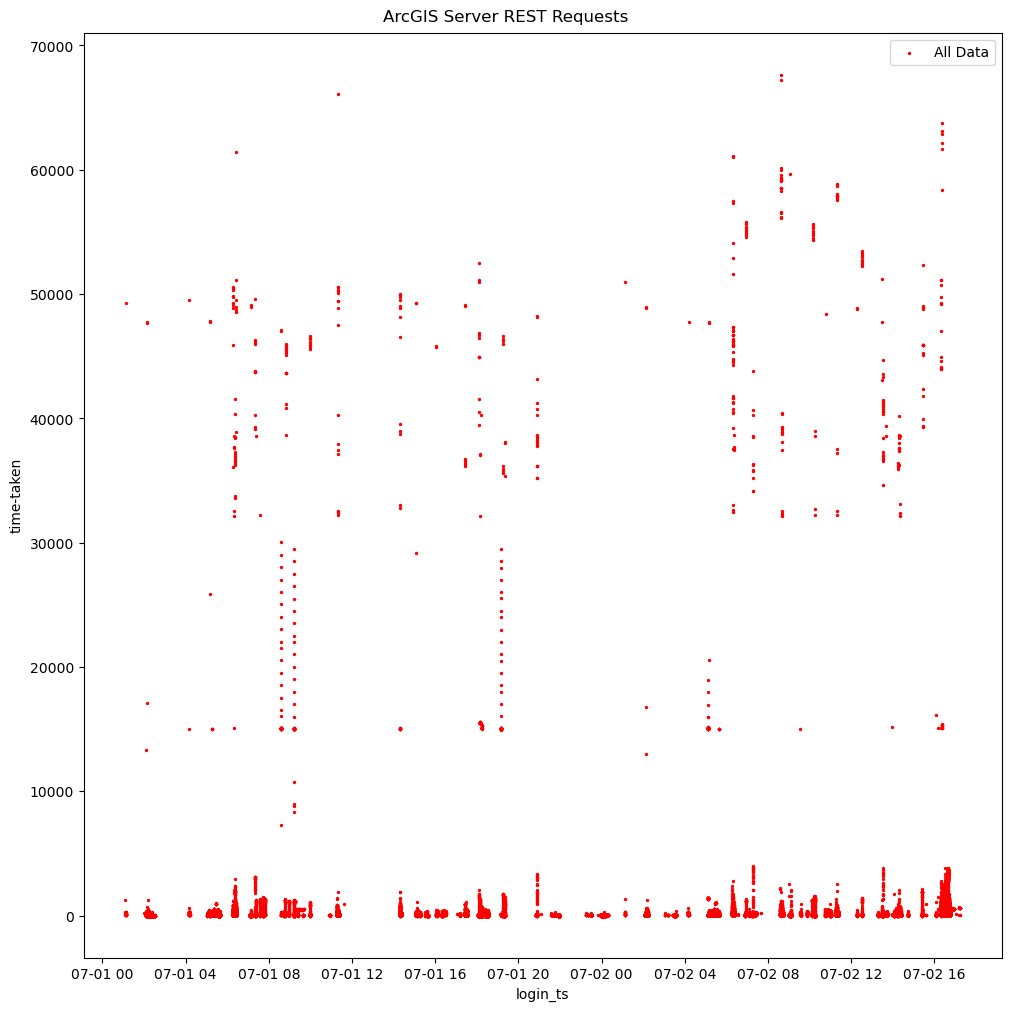

In [35]:
# Just plot it all!
fig, axs = plt.subplots(1, 1, sharex=False, constrained_layout=True, figsize=(10, 10))
fig.suptitle('ArcGIS Server REST Requests')
source_df.plot(x='login_ts', y='time-taken', ax=axs, kind='scatter', s=2, marker = 'o', color='#ff0000', label='All Data', legend=True)
plt.show()

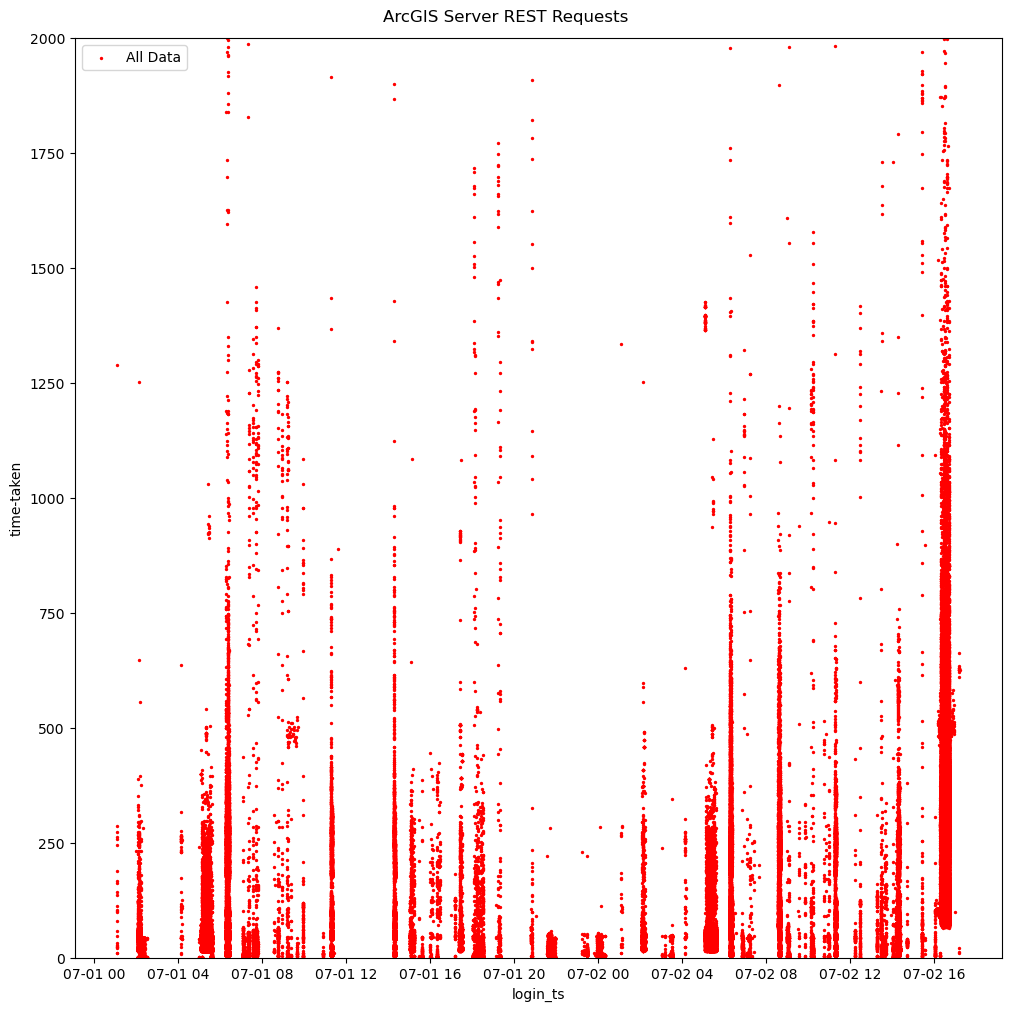

In [36]:
# Plot it all but constrain y-axis.
fig, axs = plt.subplots(1, 1, sharex=False, constrained_layout=True, figsize=(10, 10))
fig.suptitle('ArcGIS Server REST Requests')
source_df.plot(x='login_ts', y='time-taken', ax=axs, kind='scatter', s=2, marker = 'o', color='#ff0000', label='All Data', legend=True)
axs.set_ylim(0,2000)
plt.show()

0 : {'start': 202507010700, 'end': 202507011800}
1 : {'start': 202507020700, 'end': 202507021800}


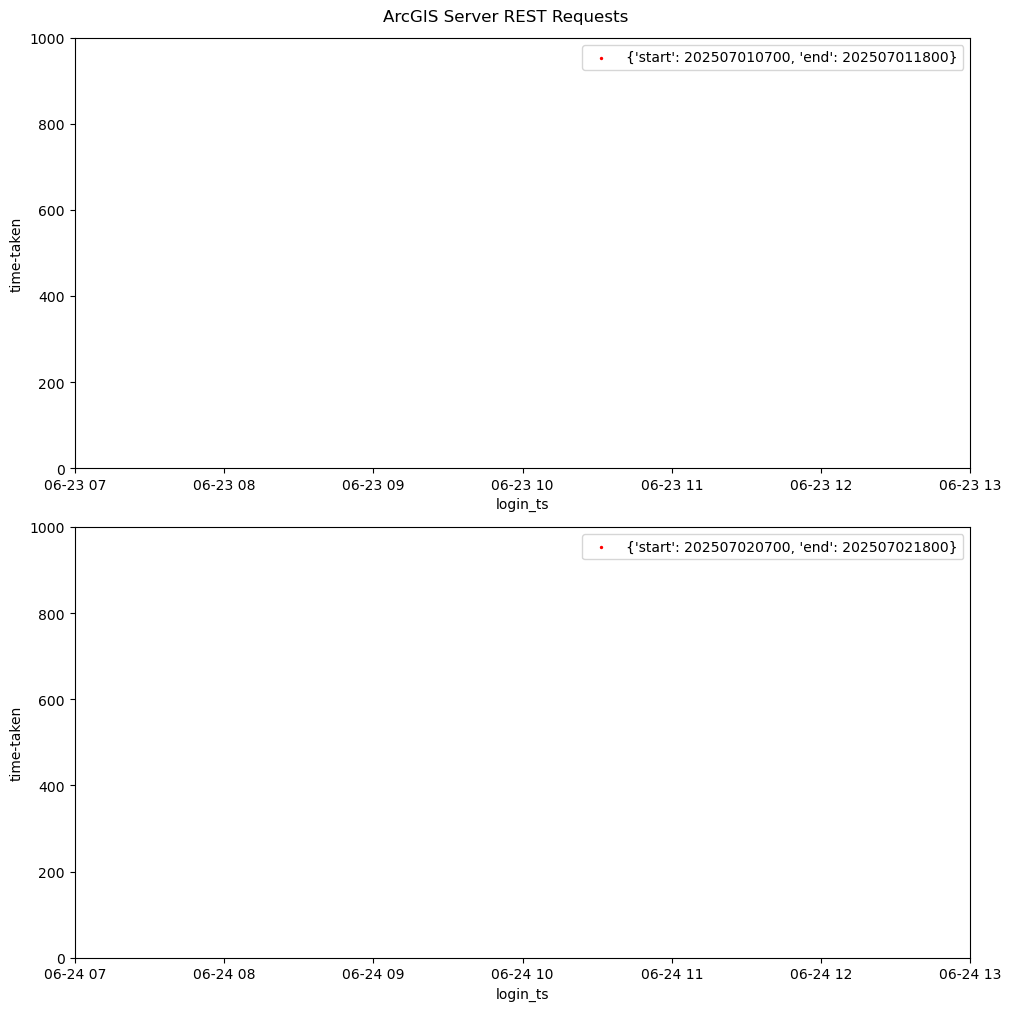

In [20]:
# Compare all results for two different dates.
dates = []
dates.append({"start":202507010700,"end":202507011800})
dates.append({"start":202507020700,"end":202507021800})

fig, axs = plt.subplots(len(dates), 1, sharex=False, constrained_layout=True, figsize=(10, 10))
fig.suptitle('ArcGIS Server REST Requests')

i = 0
for d in dates:
    print('{} : {}'.format(i, d))
    temp_df = source_df[(source_df['YYYYMMDDHHMM']>=d['start']) & (source_df['YYYYMMDDHHMM']<=d['end'])]
    temp_df.plot(x='login_ts', y='time-taken', ax=axs[i], kind='scatter', s=2, color='#ff0000', label='{}'.format(d))

    axs[i].set_ylim(0,1000)
    i += 1

# Set the x-axis limits to either show the timeframe desired, or make sure the scale range is consistent!
axs[0].set_xlim(datetime.datetime(2025, 6, 23,  7, 0, 0), datetime.datetime(2025, 6, 23,  13, 0, 0))
axs[1].set_xlim(datetime.datetime(2025, 6, 24,  7, 0, 0), datetime.datetime(2025, 6, 24,  13, 0, 0))
    
plt.show()

In [104]:
# Compare all results for two different dates split by server.
dates = []
dates.append({"start":202506230700,"end":202506231300})
dates.append({"start":202506240700,"end":202506241300})

fig, axs = plt.subplots(len(dates), 1, sharex=False, constrained_layout=True, figsize=(10, 10))
fig.suptitle('ArcGIS Server REST Requests')

i = 0
for d in dates:
    print('{} : {}'.format(i, d))
    t1 = source_df[(source_df['source_site']=='ap1sa') & (source_df['YYYYMMDDHHMM']>=d['start']) & (source_df['YYYYMMDDHHMM']<=d['end'])]
    t2 = source_df[(source_df['source_site']=='ap3sa') & (source_df['YYYYMMDDHHMM']>=d['start']) & (source_df['YYYYMMDDHHMM']<=d['end'])]
    t1.plot(x='login_ts', y='time-taken', ax=axs[i], kind='scatter', s=2, color='#ff0000', label='ap1sa')
    t2.plot(x='login_ts', y='time-taken', ax=axs[i], kind='scatter', s=2, color='#00ff00', label='ap3sa')
    
    axs[i].set_ylim(0,1000)
    i += 1

# Set the x-axis limits to either show the timeframe desired, or make sure the scale range is consistent!
axs[0].set_xlim(datetime.datetime(2025, 6, 23,  7, 0, 0), datetime.datetime(2025, 6, 23,  13, 0, 0))
axs[1].set_xlim(datetime.datetime(2025, 6, 24,  7, 0, 0), datetime.datetime(2025, 6, 24,  13, 0, 0))
    
plt.show()

0 : {'start': 202506230700, 'end': 202506231300}
1 : {'start': 202506240700, 'end': 202506241300}


In [ ]:
# Compare all results for two different dates split by server and url.
urls = []
urls.append('/arcgis/rest/services/perils/mapserver/identify')
urls.append('/arcgis/rest/services/global_exposure')
urls.append('/arcgis/rest/services/reference_data')
urls.append('/arcgis/rest/services/noneditablelayers')

labels = []
labels.append('perils identify')
labels.append('global_exposure')
labels.append('reference_data')
labels.append('noneditablelayers')

colours = []
colours.append('#ff0000')
colours.append('#00ff00')
colours.append('#0000ff')
colours.append('#ffff00')

dates = []
dates.append({"start":202506300700,"end":202506301300})
dates.append({"start":202506240700,"end":202506241300})

fig, axs = plt.subplots(len(dates), 1, sharex=False, constrained_layout=True, figsize=(10, 10))
fig.suptitle('ArcGIS Server REST Requests')

i = 0
for d in dates:
    df_1 = source_df[(source_df['source_site']=='ap1sa') &(source_df['YYYYMMDDHHMM']>=d['start']) & (source_df['YYYYMMDDHHMM']<=d['end'])]
    df_2 = source_df[(source_df['source_site']=='ap3sa') &(source_df['YYYYMMDDHHMM']>=d['start']) & (source_df['YYYYMMDDHHMM']<=d['end'])]
    
    c = 0
    for url in urls:
        df_temp_1 = df_1[(df_1['cs-uri-stem'].str.contains(url, na=False, case=False))]
        df_temp_2 = df_2[(df_2['cs-uri-stem'].str.contains(url, na=False, case=False))]
        
        label_1 = '{} ({})'.format('ap1sa', labels[c])
        label_2 = '{} ({})'.format('ap3sa', labels[c])

        df_temp_1.plot(x='login_ts', y='time-taken', ax=axs[i], kind='scatter', s=2, color=colours[c], marker = 'o', label=label_1)
        df_temp_2.plot(x='login_ts', y='time-taken', ax=axs[i], kind='scatter', s=2, color=colours[c], marker = 's', label=label_2)
        
        c += 1

    axs[i].set_ylim(0,500)
    i += 1

# Plot some vertical lines and labels.
axs[len(dates)-1].annotate('Service Recycle', xy=(datetime.datetime(2025, 6, 24, 10, 0, 0), 480), xycoords='data')
axs[len(dates)-1].annotate('Service Recycle', xy=(datetime.datetime(2025, 6, 24, 11, 0, 0), 480), xycoords='data')
axs[len(dates)-1].axvline(x=datetime.datetime(2025, 6, 24, 10, 0, 0), color='#000000', label='Service Recycle')
axs[len(dates)-1].axvline(x=datetime.datetime(2025, 6, 24, 11, 0, 0), color='#000000', label='Service Recycle')

# Plot a horizontal line.
plt.axhline(y=50, color='#aaaaaa', linestyle='-')

plt.show()